# Power Budget

# Step 7

## Description


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Config ---
power_req_file = "power_requirements.csv"
power_modes_file = "power_modes.csv"
output_folder = "power_analysis"
os.makedirs(output_folder, exist_ok=True)

# --- Margins by Source ---
margins = {
    "Computed": 0.10,
    "Datasheet": 0.10,
    "Flight Model": 0.02,
    "Generic Assumption": 0.20,
    "LAB Measurement": 0.05,
    "Requirement": 0.25,
    "Supplier": 0.00
}

# --- Load data ---
power_requirements = pd.read_csv(power_req_file)
power_modes = pd.read_csv(power_modes_file)

# Create lookup: {(Subsystem, Mode): Adjusted Power}
power_lookup = {}
for _, row in power_requirements.iterrows():
    subsystem = row['Subsystem'].strip()
    subsys_mode = str(row['Subsys Mode']).strip()
    base_power = float(row['Power Consumption (W)'])
    source = row['Source'].strip()
    margin = margins.get(source, 0.0)  # default to 0% if not found
    adjusted_power = base_power * (1 + margin)
    power_lookup[(subsystem, subsys_mode)] = adjusted_power

# --- Build matrix ---
matrix_data = []
for _, row in power_modes.iterrows():
    mode_name = str(row["Mode"]).strip()
    total_power = 0
    mode_data = {"Mode": mode_name}
    for subsystem, status in row.iloc[1:].items():
        key = (subsystem.strip(), str(status).strip())
        power = power_lookup.get(key, 0.0)
        mode_data[subsystem.strip()] = power
        total_power += power
    mode_data["Total Power (W)"] = total_power
    matrix_data.append(mode_data)

matrix_df = pd.DataFrame(matrix_data)
matrix_csv = os.path.join(output_folder, "power_matrix_structured.csv")
matrix_df.to_csv(matrix_csv, index=False)

# --- Plot: Total power per mode with highlight ---
plt.figure(figsize=(10, 6))
colors = ["lightblue"] * len(matrix_df)
max_idx = matrix_df["Total Power (W)"].idxmax()
colors[max_idx] = "orange"
bars = plt.bar(matrix_df["Mode"], matrix_df["Total Power (W)"], color=colors)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Power (W)")
plt.title("Total Power Consumption per Mode (Highest Highlighted)")
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f"{bar.get_height():.1f}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
total_bar_chart = os.path.join(output_folder, "total_power_per_mode_highlighted.png")
plt.savefig(total_bar_chart, dpi=300)
plt.close()

# --- Plot: Stacked bar of subsystems ---
subsystems = [c for c in matrix_df.columns if c not in ["Mode", "Total Power (W)"]]
matrix_df.set_index("Mode", inplace=True)
matrix_df[subsystems].plot(kind="bar", stacked=True, figsize=(12, 7), colormap="tab20")
plt.ylabel("Power (W)")
plt.title("Subsystem Power Consumption by Mode (Stacked)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
stacked_bar_chart = os.path.join(output_folder, "stacked_power_by_subsystem.png")
plt.savefig(stacked_bar_chart, dpi=300)
plt.close()

print(f"Analysis updated with margins applied. Outputs in {output_folder}")


Analysis updated with margins applied. Outputs in power_analysis


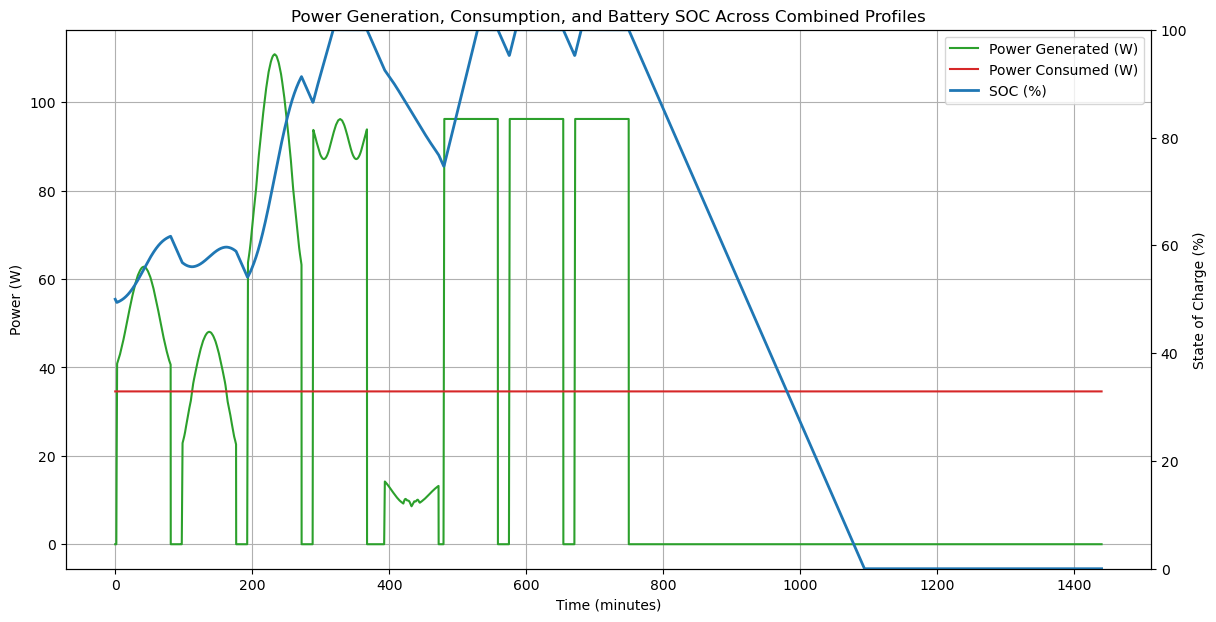

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# === Load Inputs ===
mode_schedule = pd.read_csv("mode_schedule.csv")
power_modes = pd.read_csv("power_matrix_structured.csv")

# === Load and combine all power profiles ===
profile_files = [
    "min_orbit_500_ltan_10_output_fault_1_VELOCITY_NADIR.csv",
    "min_orbit_500_ltan_10_output_fault_2_VELOCITY_NADIR.csv",
    "min_orbit_500_ltan_10_output_plus10_VELOCITY_NADIR.csv",
    "min_orbit_500_ltan_10_output_plus10.1_VELOCITY_SUN.csv",
    "min_orbit_500_ltan_10_output_plus10.2_VELOCITY_GS.csv",
    "min_orbit_500_ltan_10_output_plus10.3_SUN_NADIR.csv",
    "min_orbit_500_ltan_10_output_plus10.4_SUN_VELOCITY.csv",
    "min_orbit_500_ltan_10_output_plus10.5_SUN_GS.csv"
]

combined_profiles = []
time_offset = 0

for file in profile_files:
    df = pd.read_csv(file)
    if "ELAPSED_TIME_SEC" in df.columns and "POWER_GENERATION_WATTS" in df.columns:
        df["ELAPSED_TIME_SEC"] = df["ELAPSED_TIME_SEC"] - df["ELAPSED_TIME_SEC"].iloc[0] + time_offset
        time_offset = df["ELAPSED_TIME_SEC"].iloc[-1]  # Update offset for next file
        combined_profiles.append(df[["ELAPSED_TIME_SEC", "POWER_GENERATION_WATTS"]])
    else:
        print(f"Skipping {file}: Missing required columns")

combined_profile_df = pd.concat(combined_profiles, ignore_index=True)

# === Battery Parameters ===
battery_capacity_Wh = 198.24  # Configurable
battery_capacity_J = battery_capacity_Wh * 3600
initial_soc = 0.5  # 50%

# === Orbit Parameters ===
orbit_duration = 90 * 60  # 90 minutes in seconds

# === Map mode power consumption ===
mode_power_map = power_modes.set_index("Mode")["Total Power (W)"].to_dict()
mode_schedule["power_consumed"] = mode_schedule["mode"].map(mode_power_map)

# === Expand mode schedule to fill 1 full orbit ===
current_total = mode_schedule["time in mode"].sum()
if current_total < orbit_duration:
    # Add Coasting mode to fill the gap
    mode_schedule = pd.concat([
        mode_schedule,
        pd.DataFrame([["Coasting", orbit_duration - current_total, "vel_nadir", mode_power_map["Coasting"]]],
                     columns=["mode", "time in mode", "power generated", "power_consumed"])
    ], ignore_index=True)

# === Build timeline ===
timeline = []
time_cursor = 0
for _, row in mode_schedule.iterrows():
    segment_duration = row["time in mode"]
    segment_times = np.linspace(0, segment_duration, int(segment_duration))
    segment_absolute_times = time_cursor + segment_times
    segment_power = np.interp(segment_absolute_times,
                              combined_profile_df["ELAPSED_TIME_SEC"],
                              combined_profile_df["POWER_GENERATION_WATTS"])

    for t, pg in zip(segment_absolute_times, segment_power):
        timeline.append({
            "time": t,
            "mode": row["mode"],
            "power_generated": pg,
            "power_consumed": row["power_consumed"]
        })
    time_cursor += segment_duration

timeline_df = pd.DataFrame(timeline)

# === Battery SOC Calculation ===
energy = [initial_soc * battery_capacity_J]
for i in range(1, len(timeline_df)):
    delta_energy = timeline_df["power_generated"].iloc[i] - timeline_df["power_consumed"].iloc[i]
    new_energy = energy[-1] + delta_energy  # W * 1s = J
    new_energy = max(min(new_energy, battery_capacity_J), 0)
    energy.append(new_energy)

timeline_df["battery_energy_J"] = energy
timeline_df["SOC"] = timeline_df["battery_energy_J"] / battery_capacity_J

# === Plot ===
fig, ax1 = plt.subplots(figsize=(14,7))
ax1.plot(timeline_df["time"]/60, timeline_df["power_generated"], label="Power Generated (W)", color='tab:green')
ax1.plot(timeline_df["time"]/60, timeline_df["power_consumed"], label="Power Consumed (W)", color='tab:red')
ax1.set_xlabel("Time (minutes)")
ax1.set_ylabel("Power (W)")
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(timeline_df["time"]/60, timeline_df["SOC"]*100, label="SOC (%)", color='tab:blue', linewidth=2)
ax2.set_ylabel("State of Charge (%)")
ax2.set_ylim(0, 100)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Power Generation, Consumption, and Battery SOC Across Combined Profiles")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load Inputs ===
mode_schedule = pd.read_csv("mode_schedule.csv")
power_modes = pd.read_csv("power_matrix_structured.csv")

# === Available profiles ===
profile_files = [
    "min_orbit_500_ltan_10_output_fault_1_VELOCITY_NADIR.csv",
    "min_orbit_500_ltan_10_output_fault_2_VELOCITY_NADIR.csv",
    "min_orbit_500_ltan_10_output_plus10_VELOCITY_NADIR.csv",
    "min_orbit_500_ltan_10_output_plus10.1_VELOCITY_SUN.csv",
    "min_orbit_500_ltan_10_output_plus10.2_VELOCITY_GS.csv",
    "min_orbit_500_ltan_10_output_plus10.3_SUN_NADIR.csv",
    "min_orbit_500_ltan_10_output_plus10.4_SUN_VELOCITY.csv",
    "min_orbit_500_ltan_10_output_plus10.5_SUN_GS.csv"
]

# === Load all profiles into a dictionary ===
profiles = {}
for file in profile_files:
    df = pd.read_csv(file)
    if "ELAPSED_TIME_SEC" in df.columns and "POWER_GENERATION_WATTS" in df.columns:
        df["ELAPSED_TIME_SEC"] = df["ELAPSED_TIME_SEC"] - df["ELAPSED_TIME_SEC"].iloc[0]  # normalize
        profiles[file] = df
    else:
        print(f"Skipping {file}: missing columns.")

# === Battery Parameters ===
battery_capacity_Wh = 198.24
battery_capacity_J = battery_capacity_Wh * 3600
initial_soc = 0.5  # 50%

# === Orbit Parameters ===
orbit_duration = 90 * 60  # 90 minutes

# === Map mode power consumption ===
mode_power_map = power_modes.set_index("Mode")["Total Power (W)"].to_dict()
mode_schedule["power_consumed"] = mode_schedule["mode"].map(mode_power_map)

# === Fill orbit if total < 1 orbit ===
current_total = mode_schedule["time in mode"].sum()
if current_total < orbit_duration:
    mode_schedule = pd.concat([
        mode_schedule,
        pd.DataFrame([["Coasting", orbit_duration - current_total,
                       profile_files[0], mode_power_map["Coasting"]]],
                     columns=["mode", "time in mode", "profile_file", "power_consumed"])
    ], ignore_index=True)

# === Build timeline ===
timeline = []
time_cursor = 0
for _, row in mode_schedule.iterrows():
    segment_duration = row["time in mode"]
    profile_name = row["profile_file"]
    profile_df = profiles[profile_name]

    # Interpolate power for this segment
    segment_times = np.linspace(0, segment_duration, int(segment_duration))
    segment_power = np.interp(segment_times,
                              profile_df["ELAPSED_TIME_SEC"],
                              profile_df["POWER_GENERATION_WATTS"])

    # Append to timeline with continuous time
    for t, pg in zip(segment_times, segment_power):
        timeline.append({
            "time": time_cursor + t,
            "mode": row["mode"],
            "profile": profile_name,
            "power_generated": pg,
            "power_consumed": row["power_consumed"]
        })
    time_cursor += segment_duration

timeline_df = pd.DataFrame(timeline)

# === Battery SOC Calculation ===
energy = [initial_soc * battery_capacity_J]
for i in range(1, len(timeline_df)):
    delta_energy = timeline_df["power_generated"].iloc[i] - timeline_df["power_consumed"].iloc[i]
    new_energy = energy[-1] + delta_energy
    new_energy = max(min(new_energy, battery_capacity_J), 0)
    energy.append(new_energy)

timeline_df["battery_energy_J"] = energy
timeline_df["SOC"] = timeline_df["battery_energy_J"] / battery_capacity_J

# === Plot ===
fig, ax1 = plt.subplots(figsize=(14,7))
ax1.plot(timeline_df["time"]/60, timeline_df["power_generated"], label="Power Generated (W)", color='tab:green')
ax1.plot(timeline_df["time"]/60, timeline_df["power_consumed"], label="Power Consumed (W)", color='tab:red')
ax1.set_xlabel("Time (minutes)")
ax1.set_ylabel("Power (W)")
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(timeline_df["time"]/60, timeline_df["SOC"]*100, label="SOC (%)", color='tab:blue', linewidth=2)
ax2.set_ylabel("State of Charge (%)")
ax2.set_ylim(0, 100)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Power Generation, Consumption, and Battery SOC Across Mode-Scheduled Profiles")
plt.show()
